In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import BernoulliNB


In [2]:
yelp_raw = pd.read_csv('data/yelp_labelled.txt', 
                       delimiter= '\t', 
                       header=None)


imdb_raw = pd.read_csv('data/imdb_labelled.txt', 
                       delimiter= '\t', 
                       header=None)


amazon_raw = pd.read_csv('data/amazon_cells_labelled.txt', 
                         delimiter= '\t', 
                         header=None
                        )


In [3]:
# set dataframe to source
df = yelp_raw.copy()

# df = imdb_raw.copy()

# df = amazon_raw.copy()


df.columns = ['message', 'negative']

In [4]:
df['negative'] = (df['negative'] == 0)
# Note that if you run this cell a second time everything will become false.
# So... Don't.

In [5]:
# replace punctuation 
df['message'] = df.message.str.replace(r'[^a-zA-Z\d\s:]', '')
# make lower case
df['message'] = df['message'].str.lower()

In [6]:
# split negative messages and combine into one list
negative_words = df.message[df.negative].str.cat(sep=' ').split()

positive_words = df.message[df.negative == False].str.cat(sep=' ').split()

In [7]:
# Unique Words
print('negative:', len(np.unique(negative_words)), ' positive:', len(np.unique(positive_words)))

negative: 1397  positive: 1246


In [8]:
diff = np.setdiff1d(
        ar1=negative_words, 
                      ar2=positive_words
                     )


In [9]:
new = df.copy()

for key in diff:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    new[key] = df['message'].apply(lambda x: key in x)

In [10]:
new = new.iloc[:, 2:]

In [11]:
data = new.copy()
target = df['negative']

In [12]:
data = data.applymap(lambda x: 1 if x == True else x)
data = data.applymap(lambda x: 0 if x == False else x)

In [13]:
words_50 = data.describe().T.sort_values(by='mean', 
                                         ascending=False).head(500).index.tolist()

In [14]:
new = df.copy()

for key in words_50:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    new[key] = new.message.str.contains(
        ' ' + str(key) + ' ',
        case=False
    )

In [15]:
data = new.iloc[:, 2:]
target = df['negative']

In [16]:
# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(data, target)

# Classify, storing the result in a new variable.
y_pred = bnb.predict(data)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}\nAccuracy: {}%".format(
    data.shape[0],
    (target != y_pred).sum(), round((1 - (target != y_pred).sum()/data.shape[0]) * 100, 2)
))

display(pd.crosstab(y_pred, target))

Number of mislabeled points out of a total 1000 points : 245
Accuracy: 75.5%


negative,False,True
row_0,,
False,500,245
True,0,255


In [17]:
cross_val_score(bnb, data, target, cv=5)

array([0.66 , 0.65 , 0.59 , 0.625, 0.665])

Average precision-recall score: 0.51


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.51')

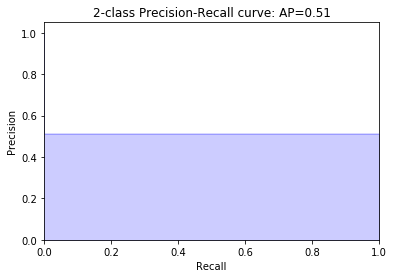

In [19]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature

from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_pred, target)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

precision, recall, _ = precision_recall_curve(y_pred, target)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))